In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Statistical and time series libraries
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Data Loading and Preprocessing




In [2]:
try:
    df = pd.read_csv('trend.csv')
    print("✓ Successfully loaded data from trend.csv")
except FileNotFoundError:
    print("❌ Error: trend.csv file not found in the current directory")
    print("Please ensure the file exists in the same folder as this notebook")
    raise
except pd.errors.EmptyDataError:
    print("❌ Error: trend.csv file is empty")
    raise
except Exception as e:
    print(f"❌ Error loading trend.csv: {str(e)}")
    raise

✓ Successfully loaded data from trend.csv


# Data preprocessing

print("=== DATA PREPROCESSING ===")
print("Original data shape:", df.shape)
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())
print("\nLast few rows:")
print(df.tail())
print(f"\nData types:")
print(df.dtypes)

# Convert Month to datetime

In [3]:

df['Month'] = pd.to_datetime(df['Month'])
print(f"\nMonth column converted to datetime: {df['Month'].dtype}")
print(f"Date range: {df['Month'].min()} to {df['Month'].max()}")

# Check for any parsing issues
if df['Month'].isnull().any():
    print("⚠️  Warning: Some dates could not be parsed")
    print("Rows with invalid dates:")
    print(df[df['Month'].isnull()])

# Set Month as index
df.set_index('Month', inplace=True)
print("Month set as index")

# Check for missing values
print(f"\nMissing values check:")
print(df.isnull().sum())

# Handle missing values (if any) - using forward fill as requested not to remove
if df.isnull().sum().sum() > 0:
    df.fillna(method='ffill', inplace=True)
    print("Missing values handled using forward fill")
else:
    print("No missing values found")

print(f"Final dataset shape: {df.shape}")
print(f"Complete date range: {df.index.min()} to {df.index.max()}")
print(f"Total months of data: {len(df)}")
print(f"Frequency: {pd.infer_freq(df.index) or 'Irregular (likely monthly)'}")

# Data quality check
print(f"\nData Quality Summary:")
print(f"- Total observations: {len(df)}")
print(f"- Complete cases: {len(df.dropna())}")
print(f"- Missing data: {df.isnull().sum().sum()} values")
print(f"- Duplicate dates: {df.index.duplicated().sum()}")

# Summary statistics for all numeric columns
print(f"\nNumeric columns summary:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    print(f"- {col}: Mean={df[col].mean():.2f}, Std={df[col].std():.2f}, Range=[{df[col].min():.2f}, {df[col].max():.2f}]")


Month column converted to datetime: datetime64[ns]
Date range: 2019-01-01 00:00:00 to 2023-12-01 00:00:00
Month set as index

Missing values check:
Total_Sales           0
Promotions            0
Festive_Season        0
Online_Sales_Ratio    0
dtype: int64
No missing values found
Final dataset shape: (60, 4)
Complete date range: 2019-01-01 00:00:00 to 2023-12-01 00:00:00
Total months of data: 60
Frequency: MS

Data Quality Summary:
- Total observations: 60
- Complete cases: 60
- Missing data: 0 values
- Duplicate dates: 0

Numeric columns summary:
- Total_Sales: Mean=24193.02, Std=3311.05, Range=[17897.71, 30584.20]
- Promotions: Mean=0.33, Std=0.48, Range=[0.00, 1.00]
- Festive_Season: Mean=0.25, Std=0.44, Range=[0.00, 1.00]
- Online_Sales_Ratio: Mean=0.35, Std=0.05, Range=[0.25, 0.47]


## 2. Exploratory Data Analysis (EDA)


=== EXPLORATORY DATA ANALYSIS ===
Basic Statistics:
        Total_Sales  Promotions  Festive_Season  Online_Sales_Ratio
count     60.000000   60.000000       60.000000            60.00000
mean   24193.018000    0.333333        0.250000             0.35200
std     3311.050975    0.475383        0.436667             0.05085
min    17897.710000    0.000000        0.000000             0.25000
25%    21870.127500    0.000000        0.000000             0.31000
50%    23990.050000    0.000000        0.000000             0.36000
75%    26230.530000    1.000000        0.250000             0.39000
max    30584.200000    1.000000        1.000000             0.47000


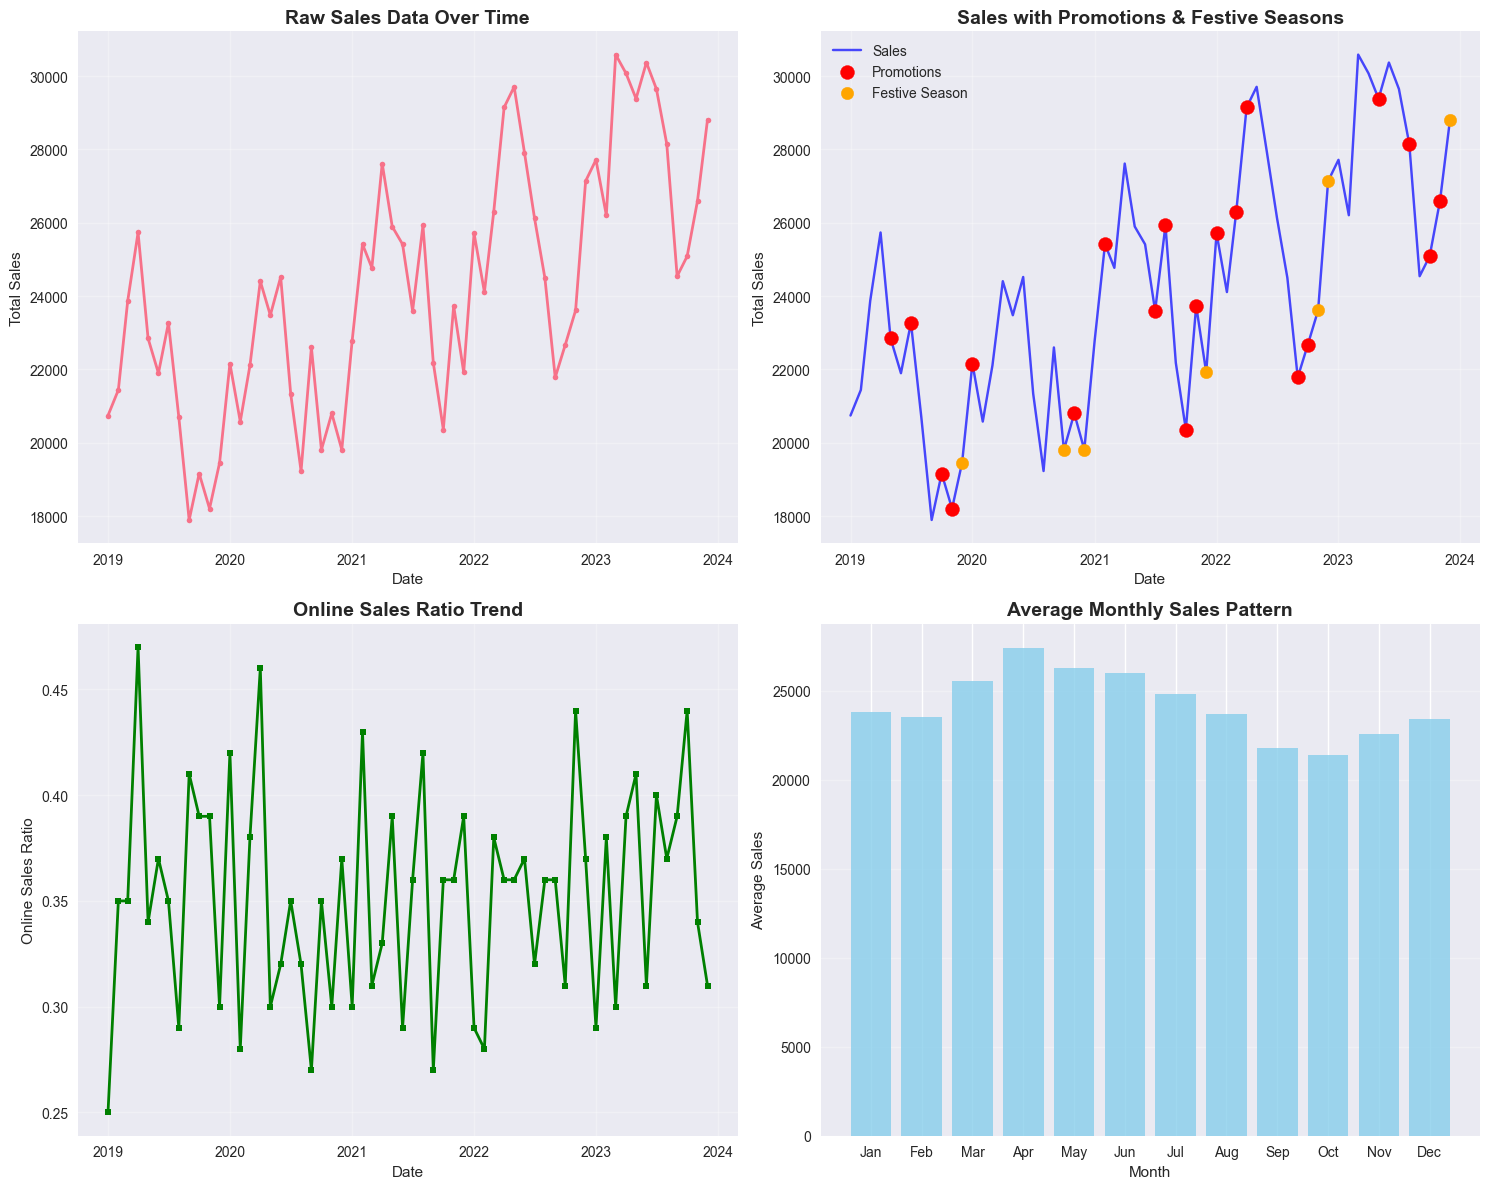

In [4]:
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Basic statistics
print("Basic Statistics:")
print(df.describe())

# Create comprehensive EDA plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Raw sales data
axes[0, 0].plot(df.index, df['Total_Sales'], marker='o', linewidth=2, markersize=4)
axes[0, 0].set_title('Raw Sales Data Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Sales')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Sales with promotions and festive seasons highlighted
axes[0, 1].plot(df.index, df['Total_Sales'], 'b-', alpha=0.7, label='Sales')
promo_dates = df[df['Promotions'] == 1].index
promo_sales = df[df['Promotions'] == 1]['Total_Sales']
axes[0, 1].scatter(promo_dates, promo_sales, color='red', s=100, label='Promotions', zorder=5)

festive_dates = df[df['Festive_Season'] == 1].index
festive_sales = df[df['Festive_Season'] == 1]['Total_Sales']
axes[0, 1].scatter(festive_dates, festive_sales, color='orange', s=80, label='Festive Season', zorder=4)

axes[0, 1].set_title('Sales with Promotions & Festive Seasons', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Total Sales')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Online Sales Ratio trend
axes[1, 0].plot(df.index, df['Online_Sales_Ratio'], 'g-', marker='s', linewidth=2, markersize=4)
axes[1, 0].set_title('Online Sales Ratio Trend', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Online Sales Ratio')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Monthly sales distribution
monthly_avg = df.groupby(df.index.month)['Total_Sales'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1, 1].bar(range(1, len(monthly_avg)+1), monthly_avg.values, color='skyblue', alpha=0.8)
axes[1, 1].set_title('Average Monthly Sales Pattern', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Sales')
axes[1, 1].set_xticks(range(1, len(monthly_avg)+1))
axes[1, 1].set_xticklabels(month_names[:len(monthly_avg)])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Moving Averages Analysis


=== MOVING AVERAGES ANALYSIS ===


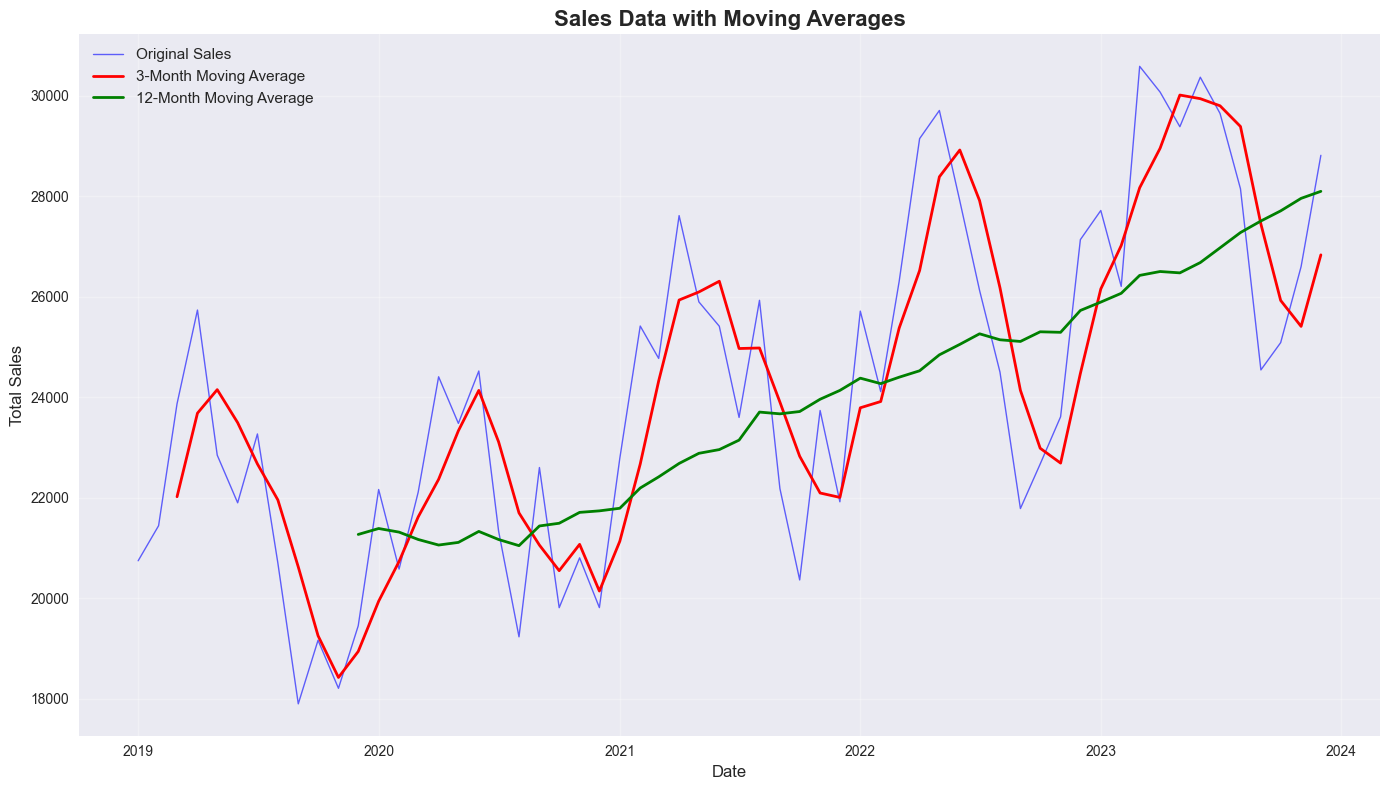

Moving averages calculated:
- 3-Month MA: Smooths short-term fluctuations
- 12-Month MA: Shows long-term trend


In [5]:

print("\n=== MOVING AVERAGES ANALYSIS ===")

# Calculate moving averages
df['MA_3'] = df['Total_Sales'].rolling(window=3).mean()
df['MA_12'] = df['Total_Sales'].rolling(window=12).mean()

# Plot moving averages
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Total_Sales'], 'b-', alpha=0.6, label='Original Sales', linewidth=1)
plt.plot(df.index, df['MA_3'], 'r-', label='3-Month Moving Average', linewidth=2)
plt.plot(df.index, df['MA_12'], 'g-', label='12-Month Moving Average', linewidth=2)

plt.title('Sales Data with Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Moving averages calculated:")
print("- 3-Month MA: Smooths short-term fluctuations")
print("- 12-Month MA: Shows long-term trend")



## 4. Seasonal Decomposition using STL



=== SEASONAL DECOMPOSITION (STL) ===


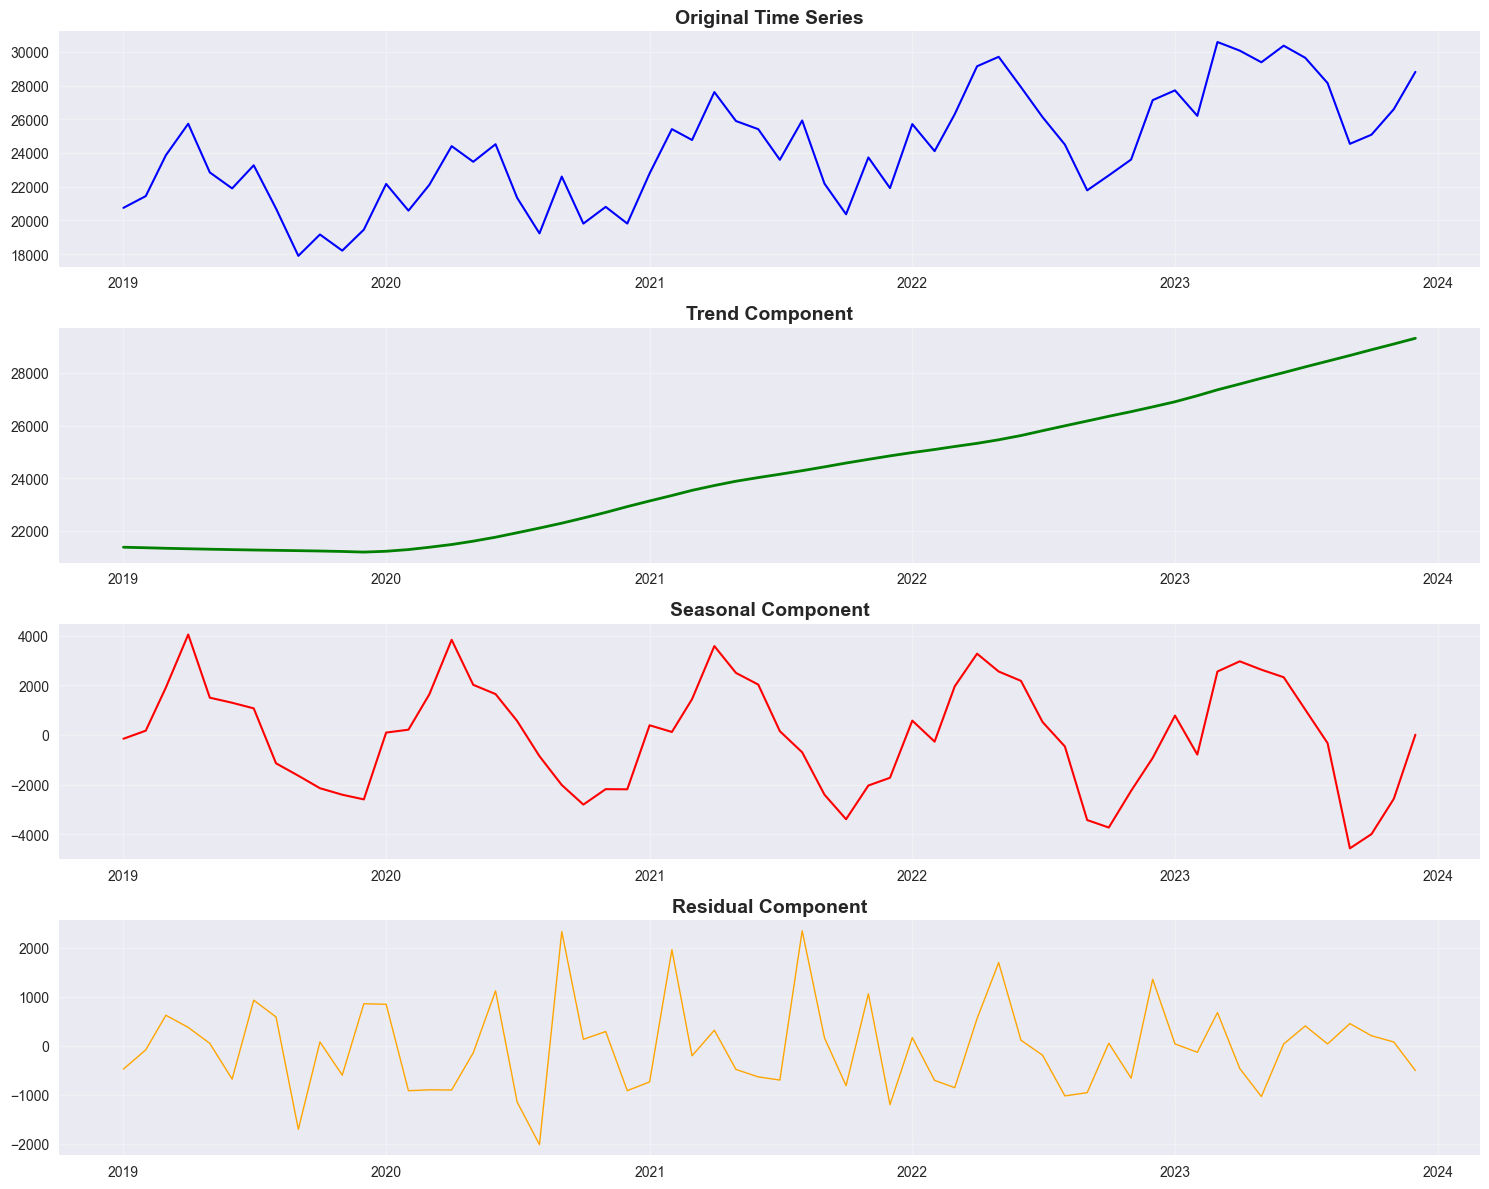

In [6]:
print("\n=== SEASONAL DECOMPOSITION (STL) ===")

# Perform STL decomposition
stl = STL(df['Total_Sales'], seasonal=7)  # Using 7 for shorter series
result = stl.fit()

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original
axes[0].plot(df.index, df['Total_Sales'], 'b-', linewidth=1.5)
axes[0].set_title('Original Time Series', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(df.index, result.trend, 'g-', linewidth=2)
axes[1].set_title('Trend Component', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(df.index, result.seasonal, 'r-', linewidth=1.5)
axes[2].set_title('Seasonal Component', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(df.index, result.resid, 'orange', linewidth=1)
axes[3].set_title('Residual Component', fontsize=14, fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Interpretation of decomposition
trend_direction = "increasing" if result.trend.iloc[-1] > result.trend.iloc[0] else "decreasing"
seasonal_strength = np.std(result.seasonal) / np.std(df['Total_Sales'])

print(f"STL Decomposition Analysis:")
print(f"- Overall trend: {trend_direction}")
print(f"- Seasonal strength: {seasonal_strength:.3f} (higher values indicate stronger seasonality)")
print(f"- Residual std: {np.std(result.resid):.2f}")

STL Decomposition Analysis:
- Overall trend: increasing
- Seasonal strength: 0.652 (higher values indicate stronger seasonality)
- Residual std: 895.83


## 5. Stationarity Check using Augmented Dickey-Fuller Test

In [8]:
print("\n=== STATIONARITY CHECK ===")

def check_stationarity(timeseries, title):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    print(f"\n{title}")
    print("=" * 50)
    
    # Perform ADF test
    result = adfuller(timeseries.dropna())
    
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    # Interpretation
    if result[1] <= 0.05:
        print("Result: Series is STATIONARY (reject null hypothesis)")
        return True
    else:
        print("Result: Series is NON-STATIONARY (fail to reject null hypothesis)")
        return False

# Check original series
is_stationary = check_stationarity(df['Total_Sales'], "Original Sales Data")

# If not stationary, try differencing
if not is_stationary:
    df['Sales_diff'] = df['Total_Sales'].diff()
    print("\nApplying first differencing...")
    is_diff_stationary = check_stationarity(df['Sales_diff'], "First Differenced Sales Data")
    
    if not is_diff_stationary:
        df['Sales_diff2'] = df['Sales_diff'].diff()
        print("\nApplying second differencing...")
        check_stationarity(df['Sales_diff2'], "Second Differenced Sales Data")


=== STATIONARITY CHECK ===

Original Sales Data
ADF Statistic: 0.809423
p-value: 0.991787
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
Result: Series is NON-STATIONARY (fail to reject null hypothesis)

Applying first differencing...

First Differenced Sales Data
ADF Statistic: -6.981027
p-value: 0.000000
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
Result: Series is STATIONARY (reject null hypothesis)


## 6. ACF and PACF Analysis


=== ACF AND PACF ANALYSIS ===


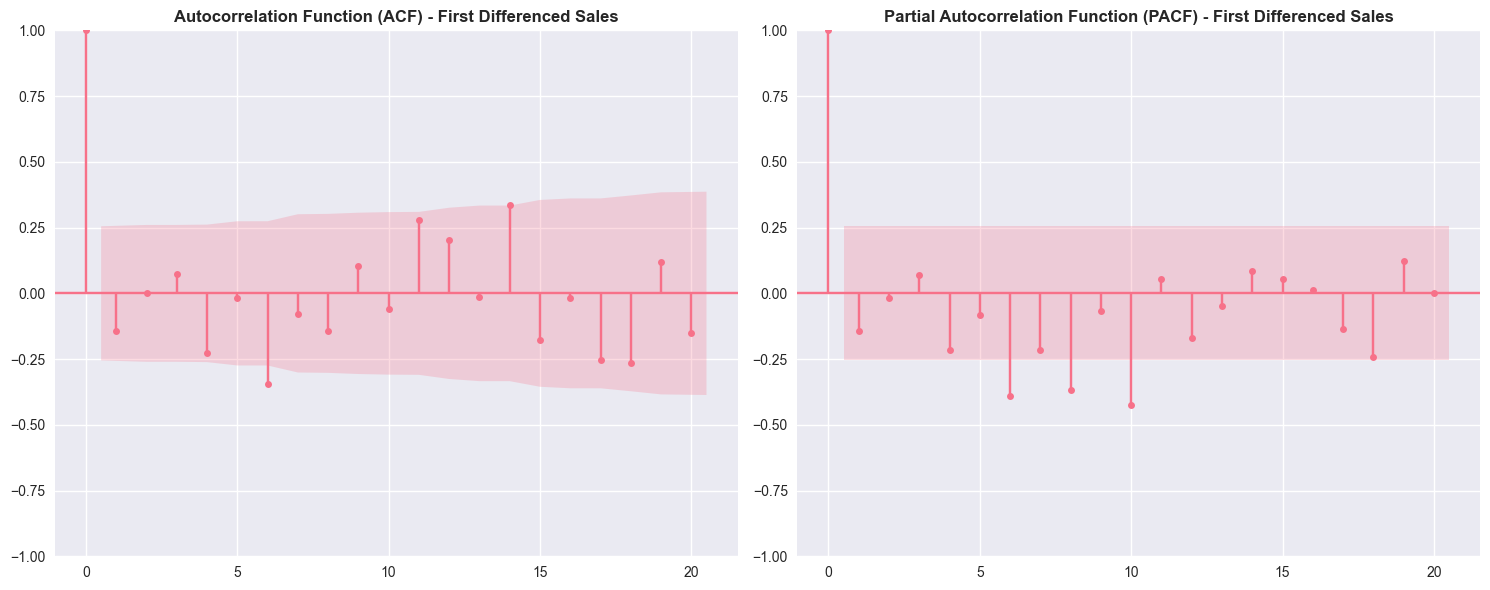

ACF and PACF plots help determine ARIMA parameters:
- ACF shows correlation with lagged values
- PACF shows partial correlation after removing effects of shorter lags


In [9]:

print("\n=== ACF AND PACF ANALYSIS ===")

# Determine the series to use for modeling
if 'Sales_diff' in df.columns:
    model_series = df['Sales_diff'].dropna()
    series_name = "First Differenced Sales"
else:
    model_series = df['Total_Sales']
    series_name = "Original Sales"

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ACF plot
plot_acf(model_series, ax=axes[0], lags=20, alpha=0.05)
axes[0].set_title(f'Autocorrelation Function (ACF) - {series_name}', fontsize=12, fontweight='bold')

# PACF plot  
plot_pacf(model_series, ax=axes[1], lags=20, alpha=0.05)
axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {series_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("ACF and PACF plots help determine ARIMA parameters:")
print("- ACF shows correlation with lagged values")
print("- PACF shows partial correlation after removing effects of shorter lags")

## 7. Train-Test Split


In [10]:
print("\n=== TRAIN-TEST SPLIT ===")

# Calculate split point (80% for training)
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point].copy()
test_data = df.iloc[split_point:].copy()

print(f"Total data points: {len(df)}")
print(f"Training set: {len(train_data)} points ({len(train_data)/len(df)*100:.1f}%)")
print(f"Testing set: {len(test_data)} points ({len(test_data)/len(df)*100:.1f}%)")
print(f"Training period: {train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')}")
print(f"Testing period: {test_data.index[0].strftime('%Y-%m')} to {test_data.index[-1].strftime('%Y-%m')}")

## 8. Model Selection and Training


=== TRAIN-TEST SPLIT ===
Total data points: 60
Training set: 48 points (80.0%)
Testing set: 12 points (20.0%)
Training period: 2019-01 to 2022-12
Testing period: 2023-01 to 2023-12


## 8. Model Selection and Training

In [11]:
print("\n=== MODEL SELECTION AND TRAINING ===")

# Prepare training data with explicit frequency
train_sales = train_data['Total_Sales'].copy()

# Ensure training data maintains frequency
if train_sales.index.freq is None:
    train_sales = train_sales.asfreq('MS')
    print("Training data frequency set to MS")

print(f"Training data frequency: {train_sales.index.freq}")
print(f"Training data shape: {train_sales.shape}")
print(f"Training data date range: {train_sales.index[0]} to {train_sales.index[-1]}")

# Try different ARIMA models
models_to_try = [
    (1, 1, 1),
    (2, 1, 1),
    (1, 1, 2),
    (2, 1, 2),
    (0, 1, 1),
    (1, 1, 0)
]

best_aic = float('inf')
best_order = None
model_results = []

print("Testing different ARIMA models...")
for order in models_to_try:
    try:
        # Create model with explicit handling of frequency
        model = ARIMA(train_sales, order=order, enforce_stationarity=False, enforce_invertibility=False)
        fitted_model = model.fit()
        aic = fitted_model.aic
        model_results.append((order, aic))
        print(f"ARIMA{order}: AIC = {aic:.2f}")
        
        if aic < best_aic:
            best_aic = aic
            best_order = order
    except Exception as e:
        print(f"ARIMA{order}: Failed to converge - {str(e)[:50]}...")

# Fit the best ARIMA model
best_arima = ARIMA(train_sales, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
fitted_arima = best_arima.fit()

print("\nARIMA Model Summary:")
print(f"Selected Model: ARIMA{best_order}")
print(f"AIC: {fitted_arima.aic:.2f}")
print(f"Log Likelihood: {fitted_arima.llf:.2f}")
print(f"Parameters:")
for i, param in enumerate(fitted_arima.params):
    print(f"  {fitted_arima.params.index[i]}: {param:.4f}")

# Check residuals
residuals = fitted_arima.resid
print(f"\nResiduals Analysis:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std: {residuals.std():.4f}")

# Ljung-Box test for residual autocorrelation
try:
    from statsmodels.stats.diagnostic import acorr_ljungbox
    ljung_box_result = acorr_ljungbox(residuals, lags=10, return_df=True)
    lb_pvalue = ljung_box_result['lb_pvalue'].iloc[-1]
    print(f"  Ljung-Box p-value: {lb_pvalue:.4f}")
    if lb_pvalue > 0.05:
        print("  ✓ Residuals appear to be white noise (good)")
    else:
        print("  ⚠ Residuals may have autocorrelation (consider model adjustment)")
except ImportError:
    print("  Ljung-Box test not available in this statsmodels version")
except Exception as e:
    print(f"  Ljung-Box test failed: {str(e)}")



=== MODEL SELECTION AND TRAINING ===
Training data frequency set to MS
Training data frequency: <MonthBegin>
Training data shape: (48,)
Training data date range: 2019-01-01 00:00:00 to 2022-12-01 00:00:00
Testing different ARIMA models...
ARIMA(1, 1, 1): AIC = 824.68
ARIMA(2, 1, 1): AIC = 831.21
ARIMA(1, 1, 2): AIC = 808.21
ARIMA(2, 1, 2): AIC = 807.60
ARIMA(0, 1, 1): AIC = 822.76
ARIMA(1, 1, 0): AIC = 841.27

ARIMA Model Summary:
Selected Model: ARIMA(2, 1, 2)
AIC: 807.60
Log Likelihood: -398.80
Parameters:
  ar.L1: -0.2190
  ar.L2: 0.2826
  ma.L1: -0.2919
  ma.L2: -0.9027
  sigma2: 4440818.9737

Residuals Analysis:
  Mean: 909.5462
  Std: 3592.7891
  Ljung-Box p-value: 0.6572
  ✓ Residuals appear to be white noise (good)


## 9. SARIMA Model (with seasonalit

In [12]:
print("\n=== SARIMA MODEL ===")

# Try SARIMA model with seasonal components
# Determine seasonal period based on data frequency
if len(train_sales) >= 24:  # Need at least 2 years for seasonal modeling
    seasonal_period = 12  # Monthly seasonality
else:
    seasonal_period = min(12, len(train_sales) // 2)  # Adjust for shorter series

print(f"Using seasonal period: {seasonal_period}")

# Try SARIMA model with seasonal components
sarima_order = best_order
seasonal_order = (1, 1, 1, seasonal_period)

try:
    sarima_model = SARIMAX(train_sales, order=sarima_order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
    fitted_sarima = sarima_model.fit(disp=False, maxiter=100)
    
    print(f"SARIMA{sarima_order}x{seasonal_order} fitted successfully")
    print(f"SARIMA AIC: {fitted_sarima.aic:.2f}")
    
    # Compare AIC values
    if fitted_sarima.aic < best_aic:
        print("SARIMA model performs better than ARIMA")
        best_model = fitted_sarima
        model_name = "SARIMA"
    else:
        print("ARIMA model performs better than SARIMA")
        best_model = fitted_arima
        model_name = "ARIMA"
        
except Exception as e:
    print(f"SARIMA model failed: {str(e)[:100]}...")
    print("Using ARIMA model for forecasting")
    best_model = fitted_arima
    model_name = "ARIMA"


=== SARIMA MODEL ===
Using seasonal period: 12
SARIMA(2, 1, 2)x(1, 1, 1, 12) fitted successfully
SARIMA AIC: 363.35
SARIMA model performs better than ARIMA


## 10. Forecasting and Evaluation

In [13]:
print(f"\n=== FORECASTING WITH {model_name} MODEL ===")

# Generate forecasts
forecast_steps = len(test_data)
forecast = best_model.forecast(steps=forecast_steps)
forecast_ci = best_model.get_forecast(steps=forecast_steps).conf_int()

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Actual': test_data['Total_Sales'].values,
    'Forecast': forecast.values,
    'Lower_CI': forecast_ci.iloc[:, 0].values,
    'Upper_CI': forecast_ci.iloc[:, 1].values
}, index=test_data.index)

print("Forecast Summary:")
print(forecast_df)



=== FORECASTING WITH SARIMA MODEL ===
Forecast Summary:
              Actual      Forecast      Lower_CI      Upper_CI
Month                                                         
2023-01-01  27715.43  28421.421617  25598.365045  31244.478188
2023-02-01  26205.44  25368.984884  22540.933693  28197.036075
2023-03-01  30584.20  26335.139023  23154.428181  29515.849864
2023-04-01  30072.38  30469.600605  27252.278656  33686.922553
2023-05-01  29382.69  30804.511267  27479.919939  34129.102596
2023-06-01  30367.51  29855.577331  26367.713912  33343.440750
2023-07-01  29646.50  27417.649395  23905.238456  30930.060334
2023-08-01  28146.92  26426.106072  22912.679254  29939.532891
2023-09-01  24543.10  25245.719066  21732.749990  28758.688142
2023-10-01  25086.18  24954.744253  21427.136858  28482.351649
2023-11-01  26598.82  26025.935299  22465.006717  29586.863882
2023-12-01  28813.32  25740.449790  22159.423891  29321.475689


## 11. Model Evaluation Metrics

In [14]:
print("\n=== MODEL EVALUATION ===")

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(forecast_df['Actual'], forecast_df['Forecast']))
mape = mean_absolute_percentage_error(forecast_df['Actual'], forecast_df['Forecast']) * 100

# Additional metrics
mae = np.mean(np.abs(forecast_df['Actual'] - forecast_df['Forecast']))
mse = mean_squared_error(forecast_df['Actual'], forecast_df['Forecast'])

print(f"Model Performance Metrics:")
print(f"- RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"- MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"- MAE (Mean Absolute Error): {mae:.2f}")
print(f"- MSE (Mean Squared Error): {mse:.2f}")

# Interpretation of metrics
print(f"\nMetrics Interpretation:")
print(f"- RMSE of {rmse:.2f} means average prediction error is ±{rmse:.0f} units")
print(f"- MAPE of {mape:.1f}% indicates {mape:.1f}% average percentage error")

if mape < 10:
    accuracy = "Excellent"
elif mape < 20:
    accuracy = "Good" 
elif mape < 50:
    accuracy = "Reasonable"
else:
    accuracy = "Poor"

print(f"- Model accuracy: {accuracy}")


=== MODEL EVALUATION ===
Model Performance Metrics:
- RMSE (Root Mean Squared Error): 1823.57
- MAPE (Mean Absolute Percentage Error): 4.78%
- MAE (Mean Absolute Error): 1379.33
- MSE (Mean Squared Error): 3325390.68

Metrics Interpretation:
- RMSE of 1823.57 means average prediction error is ±1824 units
- MAPE of 4.8% indicates 4.8% average percentage error
- Model accuracy: Excellent


## 12. Visualization of Results


=== RESULTS VISUALIZATION ===


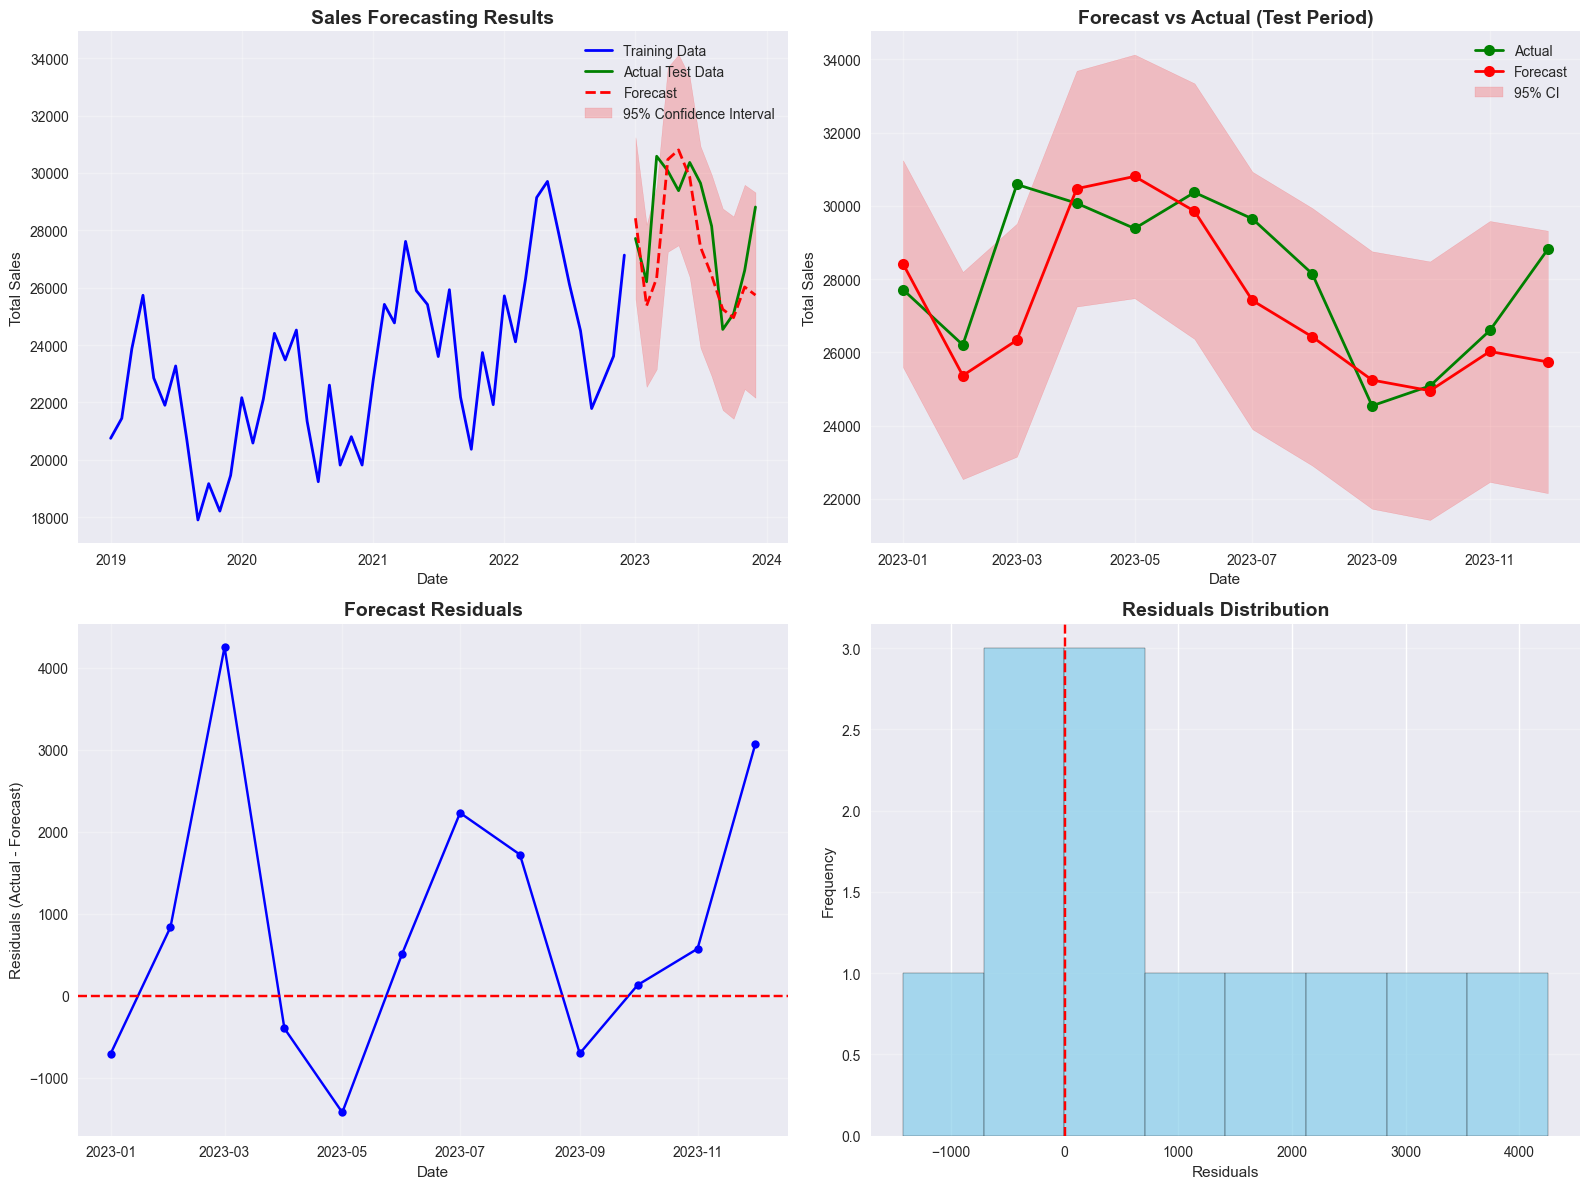

In [15]:
print("\n=== RESULTS VISUALIZATION ===")

# Create comprehensive results plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Full time series with forecast
axes[0, 0].plot(train_data.index, train_data['Total_Sales'], 'b-', label='Training Data', linewidth=2)
axes[0, 0].plot(test_data.index, test_data['Total_Sales'], 'g-', label='Actual Test Data', linewidth=2)
axes[0, 0].plot(forecast_df.index, forecast_df['Forecast'], 'r--', label='Forecast', linewidth=2)
axes[0, 0].fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], 
                       color='red', alpha=0.2, label='95% Confidence Interval')
axes[0, 0].set_title('Sales Forecasting Results', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Sales')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Forecast vs Actual (zoomed)
axes[0, 1].plot(forecast_df.index, forecast_df['Actual'], 'go-', label='Actual', markersize=8, linewidth=2)
axes[0, 1].plot(forecast_df.index, forecast_df['Forecast'], 'ro-', label='Forecast', markersize=8, linewidth=2)
axes[0, 1].fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], 
                       color='red', alpha=0.2, label='95% CI')
axes[0, 1].set_title('Forecast vs Actual (Test Period)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Total Sales')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals analysis
residuals = forecast_df['Actual'] - forecast_df['Forecast']
axes[1, 0].plot(forecast_df.index, residuals, 'bo-', markersize=6)
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_title('Forecast Residuals', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Residuals (Actual - Forecast)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals histogram
axes[1, 1].hist(residuals, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].set_title('Residuals Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 13. Business Insights and Recommendations

In [16]:
print("\n=== BUSINESS INSIGHTS AND RECOMMENDATIONS ===")

# Analyze seasonal patterns
monthly_pattern = df.groupby(df.index.month)['Total_Sales'].mean()
peak_month = monthly_pattern.idxmax()
low_month = monthly_pattern.idxmin()

# Analyze impact of promotions and festive seasons
promo_effect = df[df['Promotions'] == 1]['Total_Sales'].mean() - df[df['Promotions'] == 0]['Total_Sales'].mean()
festive_effect = df[df['Festive_Season'] == 1]['Total_Sales'].mean() - df[df['Festive_Season'] == 0]['Total_Sales'].mean()

# Online sales trend
online_trend = df['Online_Sales_Ratio'].iloc[-1] - df['Online_Sales_Ratio'].iloc[0]

print("Key Business Insights:")
print("=" * 50)
print(f"1. SEASONAL PATTERNS:")
print(f"   - Peak sales month: {peak_month} (Average: {monthly_pattern[peak_month]:.0f})")
print(f"   - Lowest sales month: {low_month} (Average: {monthly_pattern[low_month]:.0f})")
print(f"   - Seasonal variation: {((monthly_pattern.max() - monthly_pattern.min()) / monthly_pattern.mean() * 100):.1f}%")

print(f"\n2. PROMOTIONAL IMPACT:")
if promo_effect > 0:
    print(f"   - Promotions increase sales by {promo_effect:.0f} units on average ({promo_effect/df['Total_Sales'].mean()*100:.1f}%)")
else:
    print(f"   - Promotions show negative effect of {abs(promo_effect):.0f} units")

print(f"\n3. FESTIVE SEASON IMPACT:")
if festive_effect > 0:
    print(f"   - Festive seasons increase sales by {festive_effect:.0f} units on average ({festive_effect/df['Total_Sales'].mean()*100:.1f}%)")
else:
    print(f"   - Festive seasons show negative effect of {abs(festive_effect):.0f} units")

print(f"\n4. ONLINE SALES TREND:")
if online_trend > 0:
    print(f"   - Online sales ratio increased by {online_trend:.2f} ({online_trend*100:.1f} percentage points)")
else:
    print(f"   - Online sales ratio decreased by {abs(online_trend):.2f} ({abs(online_trend)*100:.1f} percentage points)")

print(f"\n5. FORECASTING ACCURACY:")
print(f"   - Model achieves {100-mape:.1f}% accuracy")
print(f"   - Suitable for short to medium-term planning")

print(f"\nRecommendations:")
print("=" * 50)
if promo_effect > 0:
    print("• Continue promotional campaigns - they show positive ROI")
else:
    print("• Review promotional strategy - current approach may need optimization")

if peak_month in [10, 11, 12]:
    print("• Prepare inventory for Q4 peak season")
elif peak_month in [3, 4, 5]:
    print("• Leverage spring season for maximum sales")

if online_trend > 0:
    print("• Invest more in online channel infrastructure")
    print("• Develop digital marketing strategies")

print("• Use forecasts for inventory planning and resource allocation")
print("• Monitor model performance and retrain quarterly")



=== BUSINESS INSIGHTS AND RECOMMENDATIONS ===
Key Business Insights:
1. SEASONAL PATTERNS:
   - Peak sales month: 4 (Average: 27394)
   - Lowest sales month: 10 (Average: 21419)
   - Seasonal variation: 24.7%

2. PROMOTIONAL IMPACT:
   - Promotions show negative effect of 265 units

3. FESTIVE SEASON IMPACT:
   - Festive seasons show negative effect of 2286 units

4. ONLINE SALES TREND:
   - Online sales ratio increased by 0.06 (6.0 percentage points)

5. FORECASTING ACCURACY:
   - Model achieves 95.2% accuracy
   - Suitable for short to medium-term planning

Recommendations:
• Review promotional strategy - current approach may need optimization
• Leverage spring season for maximum sales
• Invest more in online channel infrastructure
• Develop digital marketing strategies
• Use forecasts for inventory planning and resource allocation
• Monitor model performance and retrain quarterly


## 14. Final Summary

In [17]:
print(f"\n=== PROJECT SUMMARY ===")
print("=" * 50)
print(f"✓ Dataset analyzed: {len(df)} months of sales data")
print(f"✓ Time series components decomposed using STL")
print(f"✓ Stationarity tested using ADF test")
print(f"✓ Best model selected: {model_name}{best_order if model_name == 'ARIMA' else str(sarima_order)+'x'+str(seasonal_order)}")
print(f"✓ Model accuracy: {100-mape:.1f}% (MAPE: {mape:.1f}%)")
print(f"✓ Business insights extracted for decision-making")



=== PROJECT SUMMARY ===
✓ Dataset analyzed: 60 months of sales data
✓ Time series components decomposed using STL
✓ Stationarity tested using ADF test
✓ Best model selected: SARIMA(2, 1, 2)x(1, 1, 1, 12)
✓ Model accuracy: 95.2% (MAPE: 4.8%)
✓ Business insights extracted for decision-making
